In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time

import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.optimize as opt
from scipy.stats import crystalball

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified


Using device cuda:0


In [3]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

#Number of graphs in each
# DATA_max_events = 149090
DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [4]:
num_samples = 100
training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = num_samples, max_events = DATA_max_events)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = num_samples, max_events = MC_max_events)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = num_samples, max_events = DATA_max_events)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events)

val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "val",num_samples = num_samples, max_events = DATA_max_events)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [5]:
# SETTING UP DATA MODEL

masked_affine_flows_train_DATA = get_masked_affine(52)
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)

# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(52)
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

In [6]:
# TRAINING MC
loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_MC, MC_model, val = True, val_data = val_data_MC, num_epochs = 11, compact_num = 20)
plot_loss(loss_hist, label = "MC loss",plot_val = True, val_loss_hist = val_hist)

In [7]:
# masked_affine_flows_train_MC = get_masked_affine(52)
# distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
# masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
# masked_affine_model_MC.load("models/NF_MC/MC_july_4.pth")
# MC_model = masked_affine_model_MC.to(device)

In [8]:
# Testing MC
test(testing_data_MC, MC_model, data_type = "MC")

100%|██████████| 141/141 [00:04<00:00, 28.35it/s]

MC average loss: -69.67398834228516


In [9]:
# MC_model.save("models/NF_MC/MC_sidebands_july_10.pth")

In [12]:
# masked_affine_flows_train_DATA = get_masked_affine(52)
# distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
# masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
# masked_affine_model_DATA.load("models/NF_DATA/DATA_july_4.pth")
# DATA_model = masked_affine_model_DATA.to(device)

In [11]:
# # TRAINING DATA
# loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_DATA, DATA_model, val = True, val_data = val_data_DATA, num_epochs = 5, compact_num = 20)
# plot_loss(loss_hist, label = "DATA loss", plot_val = True, val_loss_hist = val_hist)

  0%|          | 0/1992 [05:41<?, ?it/s]

KeyboardInterrupt



In [ ]:
# DATA_model.save("models/NF_DATA/DATA_sidebands_july_10.pth")

In [13]:

# Testing DATA
test(testing_data_DATA, DATA_model, data_type = "DATA")

100%|██████████| 249/249 [00:08<00:00, 29.96it/s]

DATA average loss: -71.6358413696289


In [14]:
transformed_latent_MC = transform(testing_data_MC, MC_model)
transformed_latent_DATA = transform(testing_data_DATA, DATA_model)

100%|██████████| 249/249 [00:08<00:00, 29.92it/s]


In [15]:
transformed_latent_train_MC = transform(training_data_MC, MC_model)
transformed_latent_train_DATA = transform(training_data_DATA, DATA_model)
transformed_latent_val_MC = transform(val_data_MC, MC_model)
transformed_latent_val_DATA = transform(val_data_DATA, DATA_model)

100%|██████████| 2075/2075 [01:02<00:00, 33.26it/s]


In [16]:
# From above plotting: <transformed_latent_DATA> is the tensor with normalized DATA
# Now need to transform it back to MC version of latent space
transformed_latent_DATA_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
transformed_latent_DATA_obj.set_batch_size(num_samples)
transformed_latent_MC_obj = Latent_data(transformed_latent_MC,testing_data_MC.labels)
transformed_latent_MC_obj.set_batch_size(num_samples)

In [17]:
transformed_latent_train_DATA_obj = Latent_data(transformed_latent_train_DATA,training_data_DATA.labels)
transformed_latent_train_DATA_obj.set_batch_size(num_samples)
transformed_latent_train_MC_obj = Latent_data(transformed_latent_train_MC,training_data_MC.labels)
transformed_latent_train_MC_obj.set_batch_size(num_samples)

In [18]:
transformed_latent_val_DATA_obj = Latent_data(transformed_latent_val_DATA,val_data_DATA.labels)
transformed_latent_val_MC_obj = Latent_data(transformed_latent_val_MC,val_data_MC.labels)

In [19]:
full_pass_DATA = transform(transformed_latent_DATA_obj, MC_model, reverse = False)
full_pass_DATA_obj = Latent_data(full_pass_DATA, testing_data_DATA.labels)
full_pass_DATA_obj.set_batch_size(num_samples)

100%|██████████| 249/249 [00:07<00:00, 32.04it/s]


In [20]:
full_pass_train_DATA = transform(transformed_latent_train_DATA_obj, MC_model, reverse = False)
full_pass_train_DATA_obj = Latent_data(full_pass_train_DATA, training_data_DATA.labels)
full_pass_train_DATA_obj.set_batch_size(num_samples)

100%|██████████| 1992/1992 [01:01<00:00, 32.19it/s]


## Prediction

In [21]:
classifier = NFClassifier(num_layers = 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

  0%|          | 0/1128 [00:08<?, ?it/s]


Finished Training


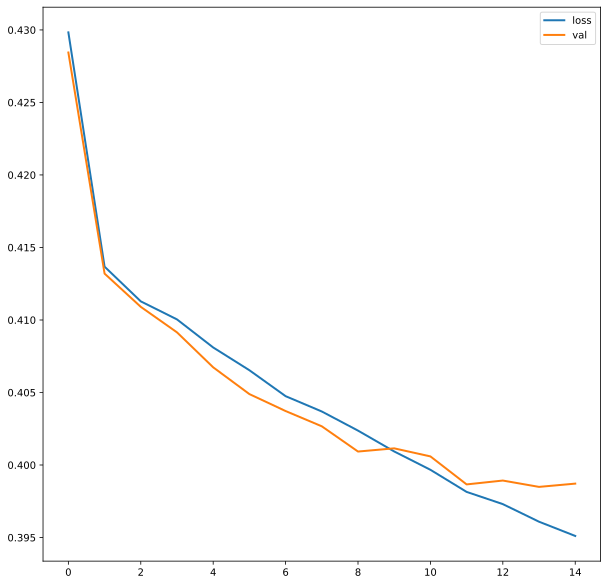

Lowest Loss: 0.39510776313906865


In [22]:
loss_hist, val_loss_hist = train_classifier(training_data_MC, classifier, criterion, optimizer, val = True, val_data = val_data_MC, num_epochs = num_epochs_classifier)

plot_loss(loss_hist, plot_val =True, val_loss_hist = val_loss_hist)

In [23]:
test_classifier_MC(testing_data_MC,classifier)

  0%|          | 0/141 [00:00<?, ?it/s]


Accuracy: 82.67431972789116


In [24]:
def test_classifier_data_DEBUG(test_data, classifier):
    outputs_data = torch.empty(test_data.num_events,2)
    #Converting normalized DATA to classifier output
    with tqdm(total=test_data.max_iter, position=0, leave=True) as pbar:
        for it in tqdm(range(test_data.max_iter), position = 0, leave=True):
            #randomly sample the latent space
            samples, labels = test_data.sample(iteration = it, _give_labels = True)
            samples = samples.to(device)
            # forward + backward + optimize
            output_batch = classifier(samples)
            for i in range(test_data.batch_size):
                outputs_data[it*test_data.batch_size + i] = output_batch[i]
    probs_data = torch.softmax(outputs_data, 1)
    return probs_data

In [25]:
probs_DATA_test = test_classifier_data_DEBUG(full_pass_DATA_obj, classifier)
probs_DATA_fp = test_classifier_data_DEBUG(full_pass_train_DATA_obj, classifier)
probs_DATA = test_classifier_data_DEBUG(training_data_DATA, classifier)
probs_MC = test_classifier_data_DEBUG(training_data_MC, classifier)

  0%|          | 0/1128 [00:05<?, ?it/s]


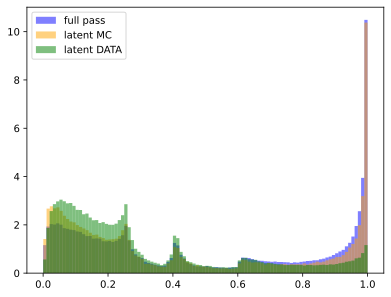

In [29]:
plt.hist(probs_DATA_fp[:,1].detach().to("cpu"),color = "blue", alpha = 0.5, bins = 100,density = True, label = "full pass");
plt.hist(probs_MC[:,1].detach().to("cpu"), color = "orange", alpha = 0.5, bins = 100,density = True, label = "latent MC");
plt.hist(probs_DATA[:,1].detach().to("cpu"), color = "green", alpha = 0.5, bins = 100,density = True, label = "latent DATA");
plt.legend()
plt.show()

roc_cut = 0 | FOM: 35.51592245232174 | purity: 0.2995231805361199


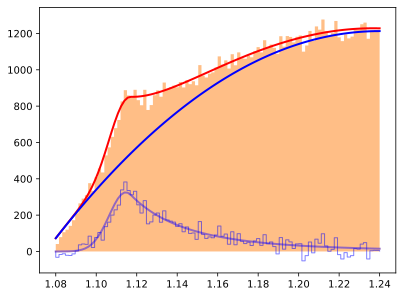

In [52]:
cut_hist = torch.empty(15,3)
roc_cut = 0
probs_data = probs_DATA_fp
#     if(i > 3):
#         continue
if(roc_cut == 0):
    argmax_Y = torch.max(probs_data, 1)[1]
else:
    argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)

masked_mass = argmax_Y * training_data_DATA.mass
#     signal_mass = argmax_Y * testing_data_DATA.mass
signal_mass = np.array([])
for j in range(masked_mass.size()[0]):
    if(masked_mass[j] != 0):
        signal_mass = np.append(signal_mass, masked_mass[j])
# Define fit function


low_high = (1.08,1.24)
bins = 100

# hdata = np.histogram(signal_mass, range=low_high, bins=bins, density=False);
hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.average(hdata[0][-10:-1]), 37, 1.24
d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

def func(x, N, beta, m, loc, scale, B, A=A, C=C):
    return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

def sig(x, N, beta, m, loc, scale):
    return N*crystalball.pdf(-x, beta, m, -loc, scale)

def bg(x, B, A=A, C=C):
    return A*(1 - B*(x - C)**2)

optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))

x = np.linspace(low_high[0],low_high[1],bins)
y = hdata[0]

plt.plot(x, func(x, *optParams), color='r')
plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
plt.plot(x, bg(x, *optParams[5:]), color='b')

# bghist = np.histogram(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high);
bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b');
# plt.savefig("plots/bghist_0_07_diff.jpeg")

r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
chi2 = np.sum(np.square(r))
chi2ndf = chi2/len(optParams)

# Get S and N before and after? #DEBUGGING: ADDED
import scipy.integrate as integrate
mu      = optParams[3]
sigma   = optParams[4]
mmin    = mu - 2*sigma
mmax    = mu + 2*sigma


binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

bin1 = int((mmin-low_high[0])/binwidth)
bin2 = int((mmax-low_high[0])/binwidth)

integral_bghist = sum(bghist[0][bin1:bin2])

integral_tothist = sum(hdata[0][bin1:bin2])
# try:
fom = integral_bghist/np.sqrt(integral_tothist)
purity =(integral_bghist)/integral_tothist
# except Exception as inst:
#     print(f"Caught {inst} | skipping cut #{i} = {roc_cut}")
print(f"roc_cut = {roc_cut} | FOM: {fom} | purity: {purity}")


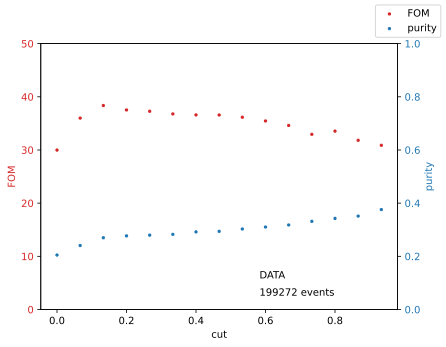

In [27]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('cut')
ax1.scatter(cut_hist[:,0], cut_hist[:,1], label = "FOM", color = "tab:red",marker = '+', s = 10)
ax1.set_ylabel('FOM', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 50])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('purity', color=color)  # we already handled the x-label with ax1
ax2.scatter(cut_hist[:,0], cut_hist[:,2], label = "purity", color = "tab:blue",marker = '+',s = 10)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])
fig.legend()
fig.text(0.6,0.2,"DATA")
fig.text(0.6,0.15,f"{len(training_data_DATA.mass)} events")
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig("plots/FOMpure/DATA_fp.jpeg")

In [51]:
roc_cut = 0.446

In [52]:
argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_DATA[:,1]],dtype=torch.long)

In [53]:
masked_mass = argmax_Y * training_data_DATA.mass

In [54]:
signal_mass = np.array([])
for i in range(masked_mass.size()[0]):
    if(masked_mass[i] != 0):
        signal_mass = np.append(signal_mass, masked_mass[i])

In [55]:
# Define fit function
low_high = (1.08,1.24)
bins = 100

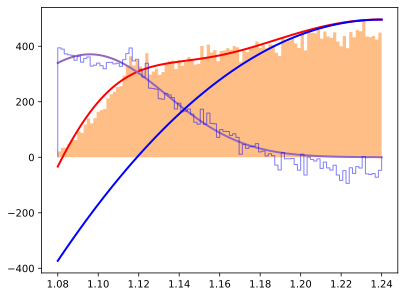

In [63]:
hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.max(hdata[0][-10:-1]), 37, 1.24
d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]
def func(x, N, beta, m, loc, scale, B, A=A, C=C):
    return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

def sig(x, N, beta, m, loc, scale):
    return N*crystalball.pdf(-x, beta, m, -loc, scale)

def bg(x, B, A=A, C=C):
    return A*(1 - B*(x - C)**2)
optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))

x = np.linspace(low_high[0],low_high[1],bins)
y = hdata[0]

plt.plot(x, func(x, *optParams), color='r')
plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
plt.plot(x, bg(x, *optParams[5:]), color='b')

bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b')
# plt.savefig("plots/bghist_fp_0_03.jpeg")

In [62]:
r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
chi2 = np.sum(np.square(r))
chi2ndf = chi2/len(optParams)

# Get S and N before and after? #DEBUGGING: ADDED
import scipy.integrate as integrate
mu      = optParams[3]
sigma   = optParams[4]
mmin    = mu - 2*sigma
mmax    = mu + 2*sigma


binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

bin1 = int((mmin-low_high[0])/binwidth)
bin2 = int((mmax-low_high[0])/binwidth)

integral_bghist = sum(bghist[0][bin1:bin2])

integral_tothist = sum(hdata[0][bin1:bin2])

fom = integral_bghist/np.sqrt(integral_tothist)
print("FOM = ",(integral_bghist)/np.sqrt(integral_tothist))
print("purity = ", (integral_bghist)/integral_tothist)

FOM =  21.346131670195764
purity =  0.26460339483515216


## FOM for diff roc_cuts

#### latent data
1. roc_cut 0: 29.95
2. roc_cut 0.13: 40
3. roc_cut 0.165: 40.1
    1. purity: 0.28
3. roc_cut: 0.18: 39.6
3. roc_cut 0.22:39.45

#### fullpass
1. roc_cut 0: 29.97 FOM
    1. purity = 0.2
2. roc_cut 0.03: 30.93
    1. purity = 0.204
1. roc_cut 0.05: 30.14
    1. purity = 0.213
2. roc_cut 0.07: 29.5
    1. purity = 0.204
2. roc_cut 0.13: 26.9
    1. purity = 0.206
3. roc_cut 0.165: 25.2 FOM
    1. purity = 0.204
3. roc_cut 0.22: